<a href="https://colab.research.google.com/github/OlgaShevel/Computer-Vision-Projects/blob/main/!binary_masks_interactiv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Создание интерактивной среды

!pip install ipympl

from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

#**Код из библиотеки mpl_interactions**

---

Однако код крайне нефункционален. Да и вообще, неудобно неотрывно водить мышкой так, чтобы все было точно.

Но... мало ли, пригодится для какой-нибудь мелочи.

Можно загружать свои файлы, можно по url

https://mpl-interactions.readthedocs.io/en/latest/examples/image-segmentation.html

In [ ]:
!pip install mpl_interactions

In [4]:
import urllib
import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_interactions import image_segmenter

In [ ]:
# Подгрузить картинку с гугл.диска или с компьютера
#file_path = '/content/8qzguaabfqoln9atn0k7cy11jsop2cdl.jpg'
#image = np.array(PIL.Image.open(file_path))

# Подгрузить картинки по url
url = "https://womanadvice.ru/sites/default/files/mainimage200x200/chem_kormit_dzhungarskih_homyakov.jpg.crop_display.jpg"
image = np.array(PIL.Image.open(urllib.request.urlopen(url)))

segmenter = image_segmenter(image, mask_colors="red", mask_alpha=0.76, figsize=(5, 5))
display(segmenter)

In [ ]:
# Вырезать, подправить фрагмент по сделанному выделению

segmenter.erasing = True

In [ ]:
segmenter.mask

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image)
plt.title('Оригинал с маскированием')

plt.subplot(122)
plt.imshow(segmenter.mask)
plt.title('Бинарная маска на основе контура', fontsize=10)

plt.show()

img1 dtype: uint8


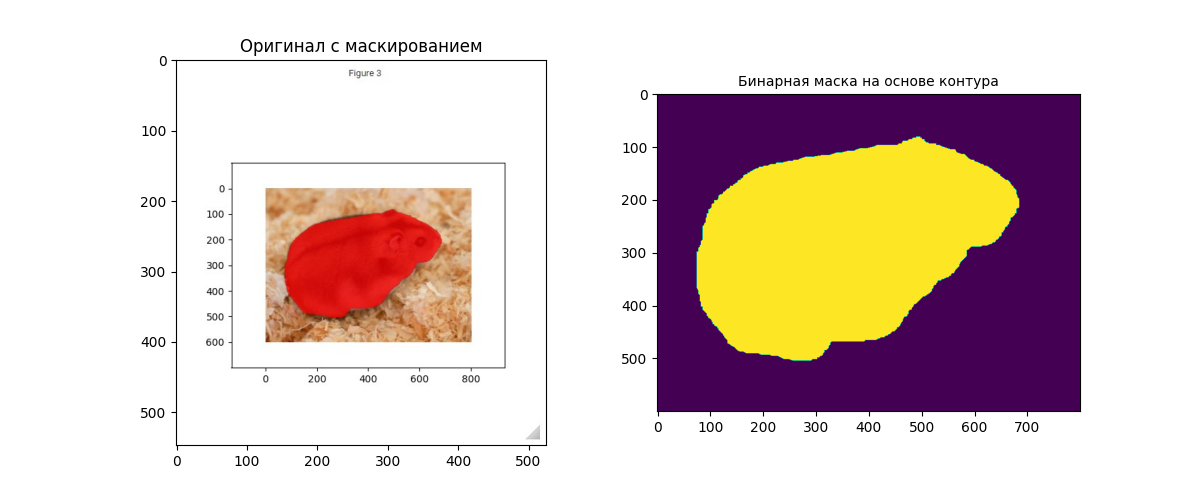

In [16]:
segmenter.mask

img1 = cv2.imread('/content/1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
print("img1 dtype:", img1.dtype)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(img1)
plt.title('Оригинал с маскированием')
plt.subplot(122)
plt.imshow(segmenter.mask)
plt.title('Бинарная маска на основе контура', fontsize=10)

plt.show()

#**Самый простой код бинарного маскирования**


---

Matplotlib + OpenCV

Без специализированных библиотек

Просто функции обработки событий на Python

1) Ставить точки - ЛКМ

2) Завершить контур - ПКМ


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/kot4.jpg'
img = cv2.imread(file_path)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

xs = []                                                                         # Списки для координат точек
ys = []
lines = []

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)

adding_points = True                                                            # Флаг для отслеживания состояния добавления точек
selected_point = None

def on_click(event):
    global adding_points, selected_point
    if adding_points:
        if event.button == 1 and event.xdata is not None and event.ydata is not None:   # ЛКМ для установки точек
            x = event.xdata
            y = event.ydata

            xs.append(x)
            ys.append(y)

            if len(xs) > 1:
                line, = ax.plot([xs[-2], xs[-1]], [ys[-2], ys[-1]], color='red')
                lines.append(line)

            ax.plot(x, y, 'ro')
            plt.draw()

def finish_drawing(event):
    global adding_points
    if event.button == 3:                                                       # ПКМ для завершения добавления точек
        adding_points = False
        print("Добавление точек завершено.")

    plt.draw()

# Подписка на события клика, перемещения мыши и отпускания кнопки --------------
cid_click = fig.canvas.mpl_connect('button_press_event', on_click)
cid_finish = fig.canvas.mpl_connect('button_press_event', finish_drawing)

# Показать график --------------------------------------------------------------
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
ax.invert_yaxis()
plt.grid()
plt.show()

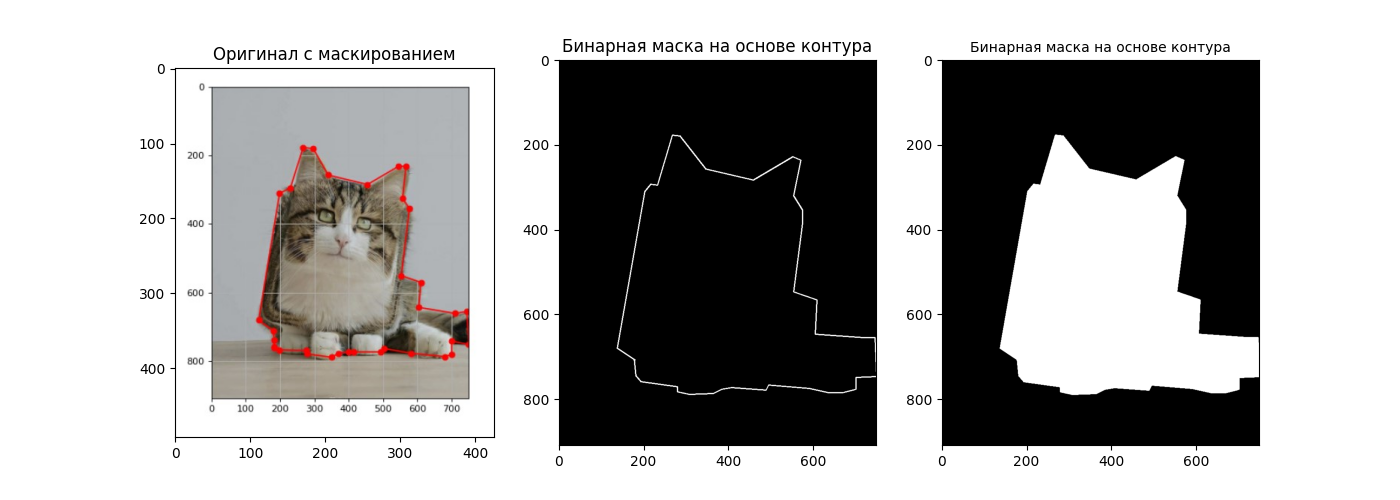

In [31]:

mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
points = np.array(list(zip(xs, ys)), dtype=np.int32)

if len(points) > 1:
    cv2.polylines(mask, [points], isClosed=False, color=255, thickness=2)

white_line = np.where(mask > 0, 255, 0).astype(np.uint8)                        # Контур белый (=255), а фон черный (=0)

if len(points) > 1:
    cv2.fillPoly(mask, [points], color=255)                                     # Рисуем залитый белым контур на маске

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Оригинал с маскированием', fontsize=10)
plt.subplot(132)
plt.imshow(white_line, cmap='gray')
plt.title('Бинарная маска на основе контура', fontsize=10)
plt.subplot(133)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска на основе контура', fontsize=10)

plt.show()

#**Код для N количества масок одного класса**


---

Matplotlib + OpenCV

Без специализированных библиотек

Просто функции обработки событий на Python


1) Ставить точки - ЛКМ

2) По завершении каждого контура - ПКМ

3) завершить весь процесс - 'q'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/kot4.jpg'
file_name = cv2.imread(file_path)
gray_image = cv2.cvtColor(file_name, cv2.COLOR_BGR2RGB)

contours = []                                                                   # Список для хранения всех контуров
current_contour = []                                                            # Текущий контур

def on_click(event):
    global current_contour, contours
    if event.button == 1 and event.xdata is not None and event.ydata is not None: # ЛКМ для установки точек
        x = event.xdata
        y = event.ydata

        current_contour.append((x, y))
        if len(current_contour) > 1:                                            # Рисуем линию между точками
            ax.plot([current_contour[-2][0], current_contour[-1][0]],
                    [current_contour[-2][1], current_contour[-1][1]], color='red')
        ax.plot(x, y, 'ro')
        plt.draw()

    elif event.button == 3:                                                     # ПКМ для завершения текущего контура
        if current_contour:
            contours.append(current_contour)
            current_contour = []                                                # Сброс текущего контура
            print("Current contour finished, start new contour.")

def on_key(event):
    if event.key == 'q':                                                        # Завершение всех контуров по нажатию 'q'
        fig.canvas.mpl_disconnect(cid_click)
        fig.canvas.mpl_disconnect(cid_key)
        plt.close(fig)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(gray_image, cmap='gray')

cid_click = fig.canvas.mpl_connect('button_press_event', on_click)
cid_key = fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

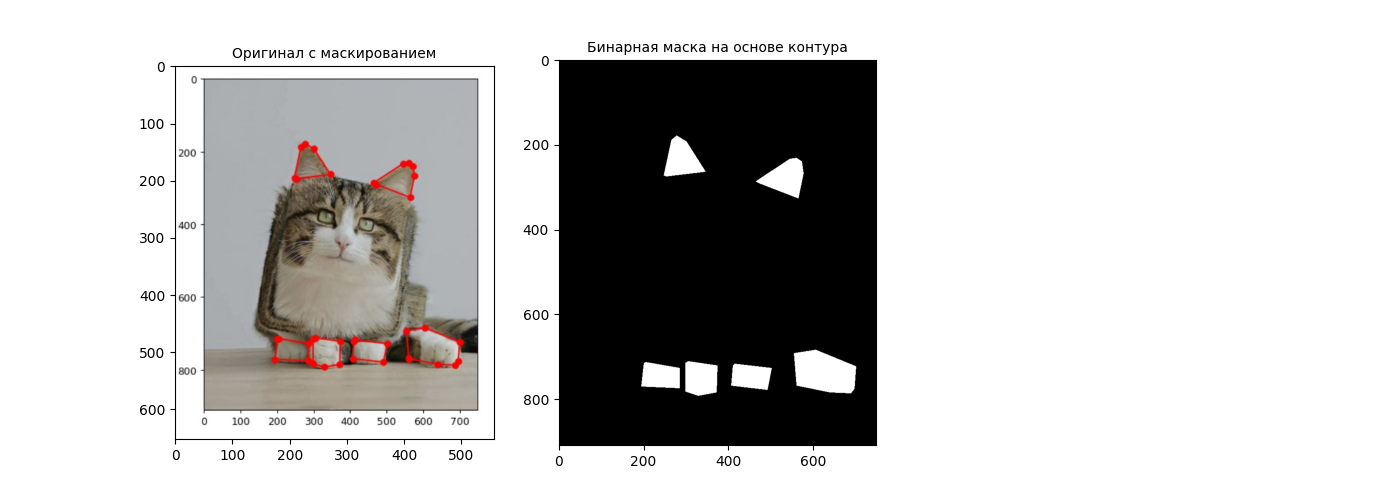

In [36]:
mask = np.zeros_like(gray_image, dtype=np.uint8)

for contour in contours:
    pts = np.array(contour, np.int32)
    pts = pts.reshape((-1, 1, 2))
    mask = cv2.polylines(mask, [pts], isClosed=True, color=(255, 255, 255))
    mask = cv2.fillPoly(mask, [pts], (255, 255, 255))

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Оригинал с маскированием', fontsize=10)
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска на основе контура', fontsize=10)

plt.show()

#**Маска класса внутри другого класса**


---

1) Ставить точки - ЛКМ

2) По завершении каждого контура - ПКМ

3) завершить весь процесс - 'q'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
file_path = '/content/kot4.jpg'
file_name = cv2.imread(file_path)
gray_image = cv2.cvtColor(file_name, cv2.COLOR_BGR2RGB)

all_contours = []
current_contour = []

def on_click(event):
    global current_contour
    if event.button == 1 and event.xdata is not None and event.ydata is not None:  # ЛКМ для установки точек
        x = int(event.xdata + 0.5)
        y = int(event.ydata + 0.5)
        current_contour.append((x, y))
        if len(current_contour) > 1:
            ax.plot([current_contour[-2][0],
                     current_contour[-1][0]], [current_contour[-2][1],
                                               current_contour[-1][1]], color='red')
        ax.plot(x, y, 'ro')  # Отображаем точку
        plt.draw()

    elif event.button == 3:                                                     # ПКМ для завершения контура
        if current_contour:
            all_contours.append(current_contour)
            current_contour = []                                                # Очистка текущего контура
            print("Контур завершен. Всего контуров:", len(all_contours))

def on_key(event):
    global all_contours
    if event.key == 'q':                                                        # Клавиша 'q' для завершения всех контуров
        fig.canvas.mpl_disconnect(cid)
        fig.canvas.mpl_disconnect(kid)
        plt.close(fig)
        print("Завершение рисования контуров. Всего контуров:", len(all_contours))


fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(gray_image, cmap='gray')
cid = fig.canvas.mpl_connect('button_press_event', on_click)
kid = fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

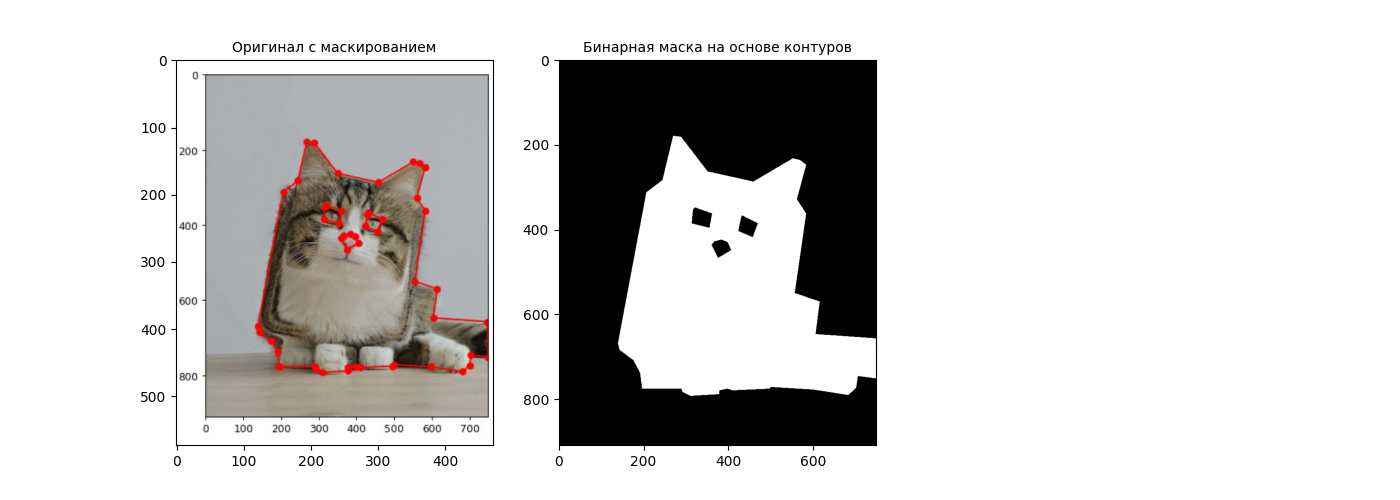

In [53]:
mask = np.zeros_like(gray_image, dtype=np.uint8)

if len(all_contours) > 0:
    outer_contour = np.array(all_contours[0], dtype=np.int32)
    mask = cv2.fillPoly(mask, [outer_contour], (255, 255, 255))                 # Заполняем первый контур белым

for contour in all_contours[1:]:
    if len(contour) > 2:
        contour = np.array(contour, dtype=np.int32)
        mask = cv2.fillPoly(mask, [contour], (0, 0, 0))                         # Заполняем все остальные контуры черным

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Оригинал с маскированием', fontsize=10)
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска на основе контуров', fontsize=10)

plt.show()

#**Редактирование маски - двигать точки после ПКМ**


---

1) Ставить точки - ЛКМ

2) Отменить последние точки - 'u'

3) Завершить контур - ПКМ

4) Перетаскивать точки мышкой, удерживая ЛКМ

5) Все завершить - 'q'


In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [ ]:
image = mpimg.imread("/content/kot4.jpg")

xs = []
ys = []
lines = []

fig, ax = plt.subplots()
adding_points = True
selected_point = None


ax.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])

transparent_layer = ax.add_patch(plt.Polygon([[0, 0]], closed=True,             # Создаем прозрачный слой
                                             fill=None, edgecolor='blue',
                                             alpha=0.5))

def on_click(event):
    global adding_points, selected_point
    if adding_points:
        if event.button == 1 and event.xdata is not None and event.ydata is not None:
            x = int(event.xdata + 0.5)
            y = int(event.ydata + 0.5)

            xs.append(x)
            ys.append(y)

            if len(xs) > 1:
                line, = ax.plot([xs[-2], xs[-1]], [ys[-2], ys[-1]], color='red')
                lines.append(line)

            ax.plot(x, y, 'ro')
            plt.draw()
    else:
        if event.button == 1 and event.xdata is not None and event.ydata is not None:
            for i, (x, y) in enumerate(zip(xs, ys)):
                if abs(event.xdata - x) < 5 and abs(event.ydata - y) < 5:       # Увеличиваем радиус для выделения точки
                    selected_point = i
                    break

def on_move(event):
    global selected_point
    if selected_point is not None and event.xdata is not None and event.ydata is not None:
        xs[selected_point] = event.xdata
        ys[selected_point] = event.ydata
        update_plot()

def finish_drawing(event):
    global adding_points
    if event.button == 3:                                                       # ПКМ для завершения добавления точек
        adding_points = False
        print("Добавление точек завершено.")

def undo_last_point(event):
    if event.key == 'u':
        if xs:
            xs.pop()
            ys.pop()

            if lines:
                line = lines.pop()
                line.remove()
            update_plot()

def on_release(event):
    global selected_point
    selected_point = None

def update_plot():
    ax.cla()                                                                    # Очистить оси
    ax.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])             # Снова отобразить изображение
    ax.set_xlim(0, image.shape[1])                                              # Установить пределы осей
    ax.set_ylim(0, image.shape[0])
    ax.invert_yaxis()                                                           # Инвертировать ось Y

    # Обновляем контур
    if len(xs) > 0:
        transparent_layer.set_xy(np.array(list(zip(xs, ys))))                   # Обновляем координаты полигона
        ax.add_patch(transparent_layer)                                         # Добавляем прозрачный слой обратно

    ax.plot(xs, ys, 'ro')
    for i in range(1, len(xs)):
        ax.plot([xs[i - 1], xs[i]], [ys[i - 1], ys[i]], color='red')

    plt.draw()                                                                  # Обновить график

def on_key(event):
    if event.key == 'q':                                                        # Завершение всех контуров по нажатию 'q'
        fig.canvas.mpl_disconnect(cid_click)
        fig.canvas.mpl_disconnect(cid_key)
        plt.close(fig)

# Подписка на события клика, перемещения мыши и отпускания кнопки --------------
cid_click = fig.canvas.mpl_connect('button_press_event', on_click)
cid_move = fig.canvas.mpl_connect('motion_notify_event', on_move)
cid_release = fig.canvas.mpl_connect('button_release_event', on_release)
cid_finish = fig.canvas.mpl_connect('button_press_event', finish_drawing)
cid_key = fig.canvas.mpl_connect('key_press_event', undo_last_point)
cid_key = fig.canvas.mpl_connect('key_press_event', on_key)

# Показать график --------------------------------------------------------------
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
ax.invert_yaxis()
plt.grid()
plt.show()

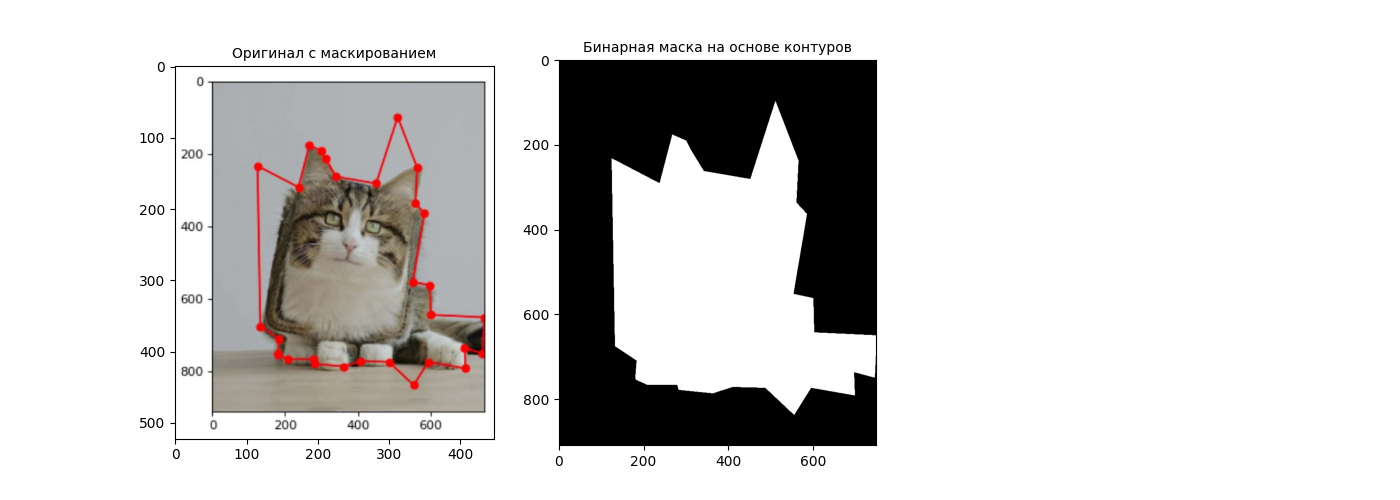

In [61]:
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
points = np.array(list(zip(xs, ys)), dtype=np.int32)

if len(points) > 1:
    cv2.fillPoly(mask, [points], color=255)

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Оригинал с маскированием', fontsize=10)
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска на основе контуров', fontsize=10)

plt.show()

#**Маска точками (mpl_point_clicker)**


---

Например, линия мешает увидеть

1) Два ЛКМ по последней точке - конец контура

2) ПКМ по точке - ее отмена

In [ ]:
!pip install mpl_point_clicker

In [63]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.draw import polygon
import imageio

In [ ]:
file_path = '/content/kot4.jpg'
image = np.array(PIL.Image.open(file_path))

fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(image)

coords = []

def onclick(event):
    if event.dblclick:
        plt.close()
    else:
        coords.append((event.xdata, event.ydata))                               # Добавляем координаты клика
        ax.plot(event.xdata, event.ydata, 'ro')
        plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

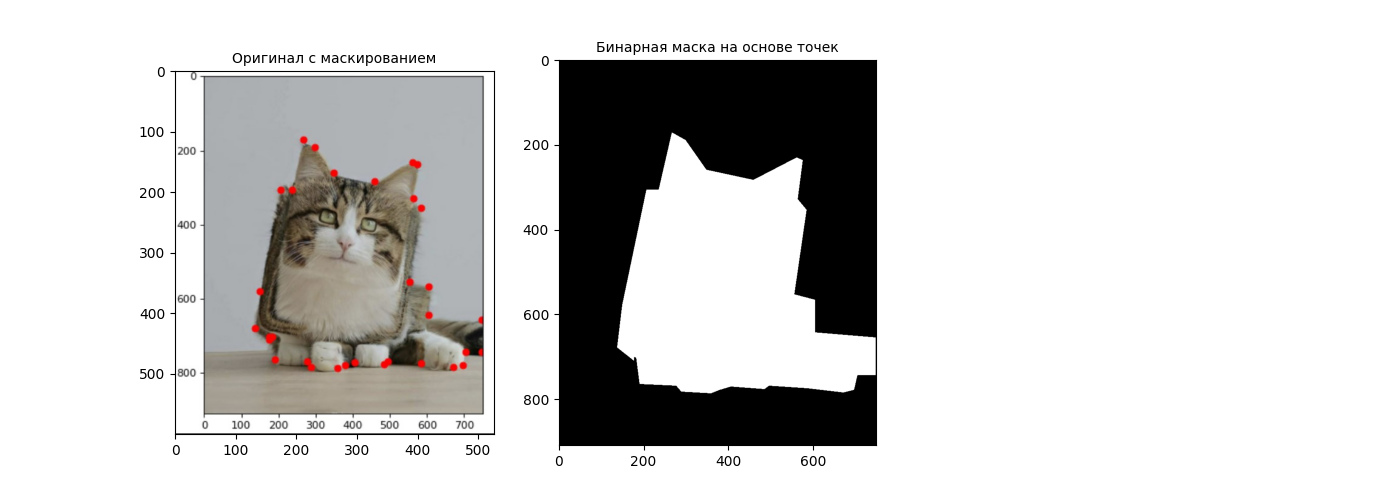

In [65]:
coords = np.array(coords)
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

if len(coords) >= 3:
    points = np.array(coords, dtype=np.int32)
    cv2.fillPoly(mask, [points], color=255)

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Оригинал с маскированием', fontsize=10)
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска на основе точек', fontsize=10)

plt.show()

#**Маски по изображениям с хорошо отделяемыми фоном и объектом (REMBG)**


---


Библиотека REMBG (предобученная нейросеть)

Если просто применить, то края могут быть смазанные. Это видно при увеличении. Поэтому делаем более резкие края

In [ ]:
!pip install rembg

In [68]:
import numpy as np
from rembg import remove
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

<class 'numpy.ndarray'>


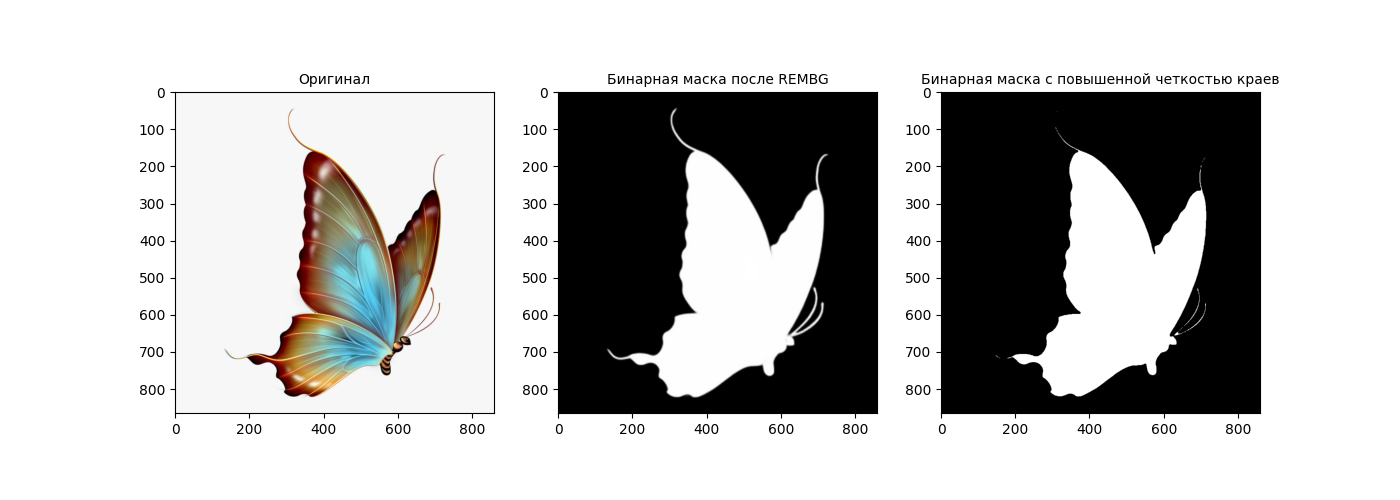

In [81]:
input_path = '/content/Babochka.png'
output_path = '/content/Babochka1.png'
image = cv2.imread(input_path)

# Удалить фон ------------------------------------------------------------------
output = remove(image, only_mask=True)
print(type(output))                                                             # Проверить тип вывода - надо массив NumPy

if not isinstance(output, np.ndarray):                                          # При необходимости конвертируем в массив NumPy
    output = np.array(output)

output = output.astype(np.uint8)
cv2.imwrite(output_path, output)
mask = cv2.imread(output_path)

# Контурный анализ на второй маске для улучшения четкости ----------------------
_, binary_mask = cv2.threshold(output, 235, 255, cv2.THRESH_BINARY)             # менять только первую цифру, ~230-235
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
contour_mask = np.zeros_like(output)
cv2.drawContours(contour_mask, contours, -1, (255), thickness=cv2.FILLED)
cv2.imwrite(output_path, contour_mask)
mask_sharp = cv2.imread(output_path)

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Оригинал', fontsize=10)
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска после REMBG', fontsize=10)
plt.subplot(133)
plt.imshow(mask_sharp, cmap='gray')
plt.title('Бинарная маска с повышенной четкостью краев', fontsize=10)

plt.show()

Часто фон бывает не таким однородным, так что после REMBG могут остаться артефакты. Их можно убрать тем же маскированием

<class 'numpy.ndarray'>


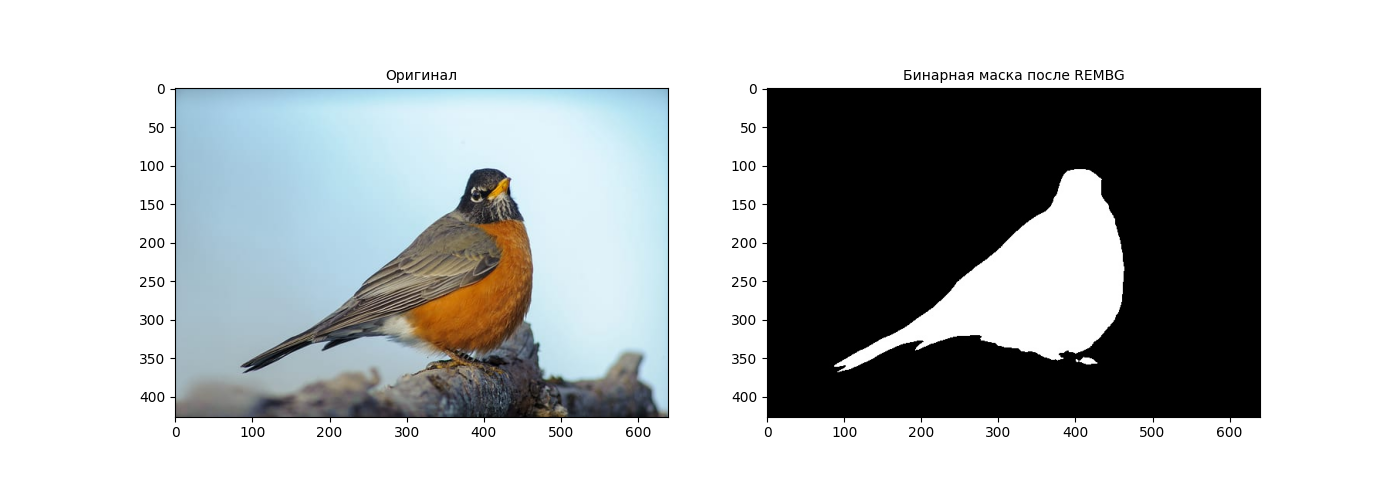

In [96]:
input_path = '/content/bird.jpg'
output_path = '/content/bird1.jpg'
input_image = cv2.imread(input_path)

output = remove(input_image, only_mask=True)
print(type(output))

if not isinstance(output, np.ndarray):
    output = np.array(output)

output = output.astype(np.uint8)

# Бнаризируем контуры
_, binary_mask = cv2.threshold(output, 230, 255, cv2.THRESH_BINARY)             # менять только первую цифру - где-то в районе 230
contours, _ = cv2.findContours(binary_mask,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
contour_mask = np.zeros_like(output)
cv2.drawContours(contour_mask, contours, -1, (255), thickness=cv2.FILLED)

# Сохранение маски
cv2.imwrite(output_path, contour_mask)
mask = cv2.imread(output_path)

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Оригинал', fontsize=10)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.title('Бинарная маска после REMBG', fontsize=10)
plt.show()

1) Контур - ЛКМ

2) Завершить - ПКМ

3) Залить:
- белым - 'w'
- черным - 'b'

4) чтобы все вместе сохранить по укзаанному пути, нажать 's'

In [ ]:
file_path = '/content/bird1.jpg'
image = cv2.imread(file_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

xs = []
ys = []
lines = []

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray_image, cmap='gray')

adding_points = True

def on_click(event):
    global adding_points
    if adding_points:
        if event.button == 1 and event.xdata is not None and event.ydata is not None:
            x = int(event.xdata)
            y = int(event.ydata)

            xs.append(x)
            ys.append(y)

            if len(xs) > 1:
                line, = ax.plot([xs[-2], xs[-1]], [ys[-2], ys[-1]], color='red')
                lines.append(line)

            ax.plot(x, y, 'ro')
            plt.draw()

def finish_drawing(event):
    global adding_points
    if event.button == 3:
        adding_points = False
        print("Добавление точек завершено.")

    plt.draw()

def fill_contour(event):
    global result_image                                                         # Объявляем переменную result_image глобальной
    if event.key == 'b':
        if len(xs) > 2:
            points = np.array([[[int(x), int(y)] for x, y in zip(xs, ys)]], dtype=np.int32)
            mask = np.zeros_like(gray_image)

            cv2.fillPoly(mask, points, 255)
            result_image = image.copy()                                         # Создаем копию оригинального изображения
            result_image[mask == 255] = [0, 0, 0]                               # Заливаем черным цветом только в области маски

            ax.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
            #plt.draw()

    elif event.key == 'w':
        if len(xs) > 2:
            points = np.array([[[int(x), int(y)] for x, y in zip(xs, ys)]], dtype=np.int32)
            mask = np.zeros_like(gray_image)

            cv2.fillPoly(mask, points, 255)
            result_image = image.copy()                                         # Создаем копию оригинального изображения
            result_image[mask == 255] = [255, 255, 255]                         # Заливаем белым цветом только в области маски

            ax.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
            #plt.draw()

def save_image(event):
   if event.key == 's':                                                         # Нажмите 's' для сохранения изображения
       if len(xs) > 2:
            cv2.imwrite('/content/final_mask.png', result_image)

cid_click = fig.canvas.mpl_connect('button_press_event', on_click)
cid_finish = fig.canvas.mpl_connect('button_press_event', finish_drawing)
cid_fill = fig.canvas.mpl_connect('key_press_event', fill_contour)
cid_save = fig.canvas.mpl_connect('key_press_event', save_image)

plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
ax.invert_yaxis()

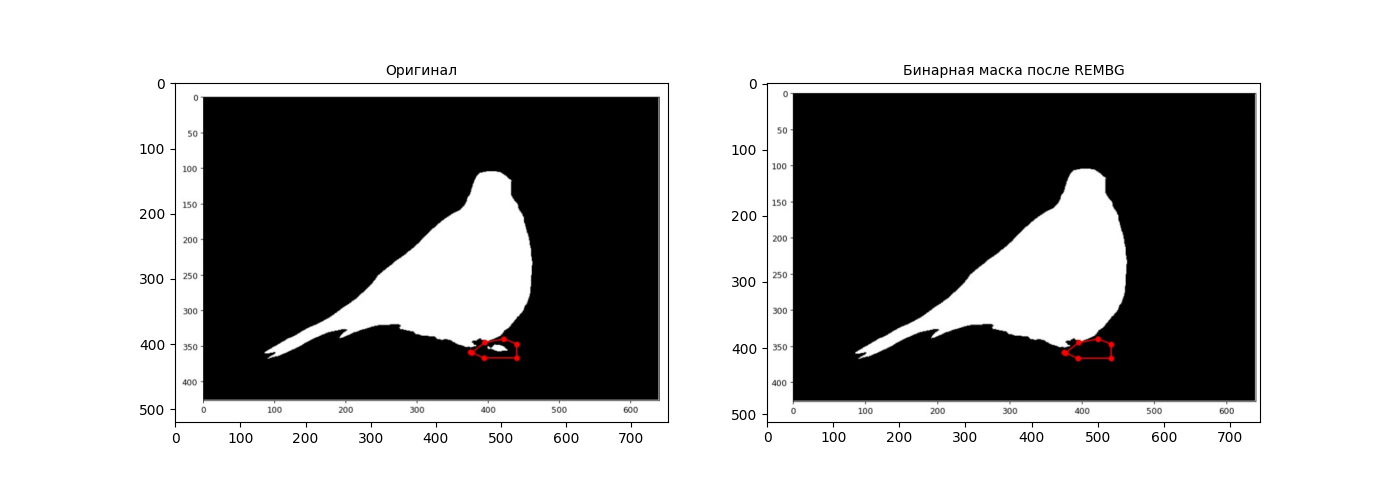

In [115]:
img1 = cv2.imread('/content/mask.jpg')
image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('/content/final_mask.jpg')
image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.imshow(image1, cmap='gray')
plt.title('Оригинал', fontsize=10)
plt.subplot(122)
plt.imshow(image2, cmap='gray')
plt.title('Бинарная маска после REMBG', fontsize=10)
plt.show()

#**Маска выпуклого контура (mpl_point_clicker)**


---

ConvexHull создает выпуклую оболочку вокруг всех выбранных точек. Маска будет представлять собой геометрическую фигуру - только по выступающим точкам

In [ ]:
!pip install mpl_point_clicker

In [120]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull                                            # маскирует по вершинам
from skimage.draw import polygon
from mpl_point_clicker import clicker
from PIL import Image

In [ ]:

file_path = '/content/air2.jpg'
image = np.array(PIL.Image.open(file_path))

fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(image)

klicker = clicker(ax, ["event"], markers=["o"], linestyle="--")
plt.show()
print(klicker.get_positions())

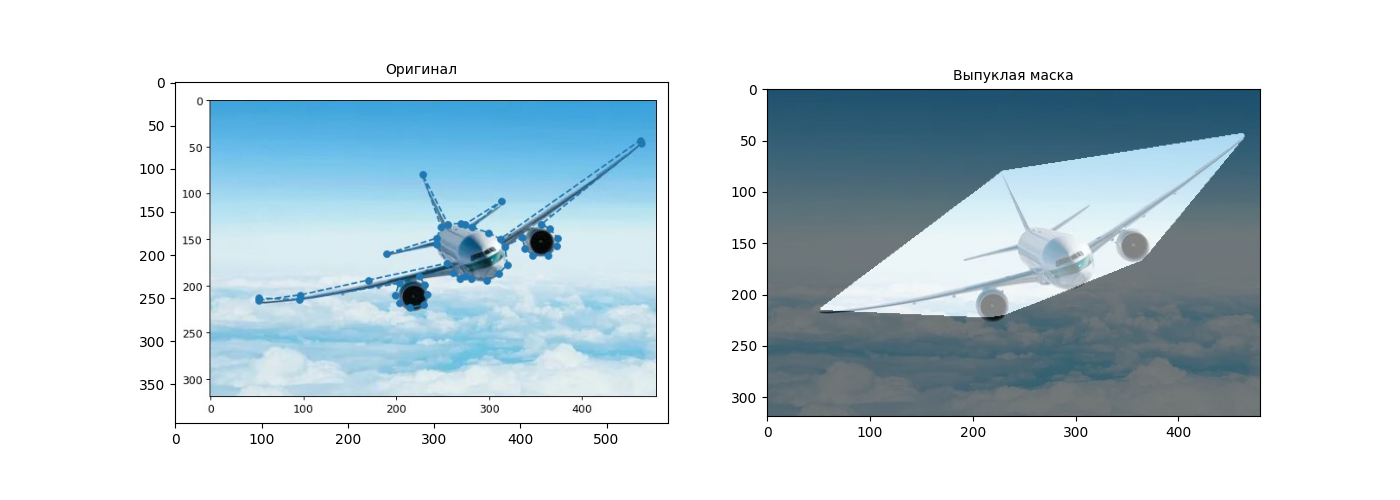

In [127]:
positions = klicker.get_positions()                                             # Получаем позиции кликов

coords = positions['event']                                                     # Координаты

mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)                   # Создать маску

if len(coords) >= 3:                                                            # Если есть хотя бы 3 точки, создаем выпуклую оболочку
    hull = ConvexHull(coords)
    hull_points = coords[hull.vertices]                                         # Координаты вершин выпуклой оболочки
    rr, cc = polygon(hull_points[:, 1], hull_points[:, 0], mask.shape)          # функции polygon - для заполнения маски
    mask[rr, cc] = True

mask = binary_fill_holes(mask)

imageio.imwrite('binary_mask.png', mask.astype(np.uint8) * 255)                 # умнож на 255 - перевод в 8-битное

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.imshow(image1, cmap='gray')
plt.title('Оригинал', fontsize=10)
plt.subplot(122)
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='gray')
plt.title('Выпуклая маска', fontsize=10)

plt.show()